# Covariates extension for CHRONOS


preliminaries

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import torch
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import PowerTransformer

In [2]:
from utils.functions import *

# Dataset

In [3]:

path = './Data/air+quality'
df = pd.read_csv(path + '/AirQualityUCI.csv', na_values=-200, parse_dates=['Date'], dayfirst=True)
df = df.rename(columns={'Date': 'date', 'Time': 'time'})    
df.head()

date      time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6       1360.0     150.0      11.9   
1  3/10/2004  19:00:00     2.0       1292.0     112.0       9.4   
2  3/10/2004  20:00:00     2.2       1402.0      88.0       9.0   
3  3/10/2004  21:00:00     2.2       1376.0      80.0       9.2   
4  3/10/2004  22:00:00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [4]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  8991.000000  8991.000000  8991.000000  
mean     18.317829    49.234201     1.025530  
std       8.832116    17.316892     0.403813  
min      -1.900000     9.200000     0.184700  
25%      11.800000    35.800000     0.736800  
50%      17.800000    49.600000     0.995400  
75%      24.400000    62.500000     1.313700  
max      44.600000    88.700000     2.231000

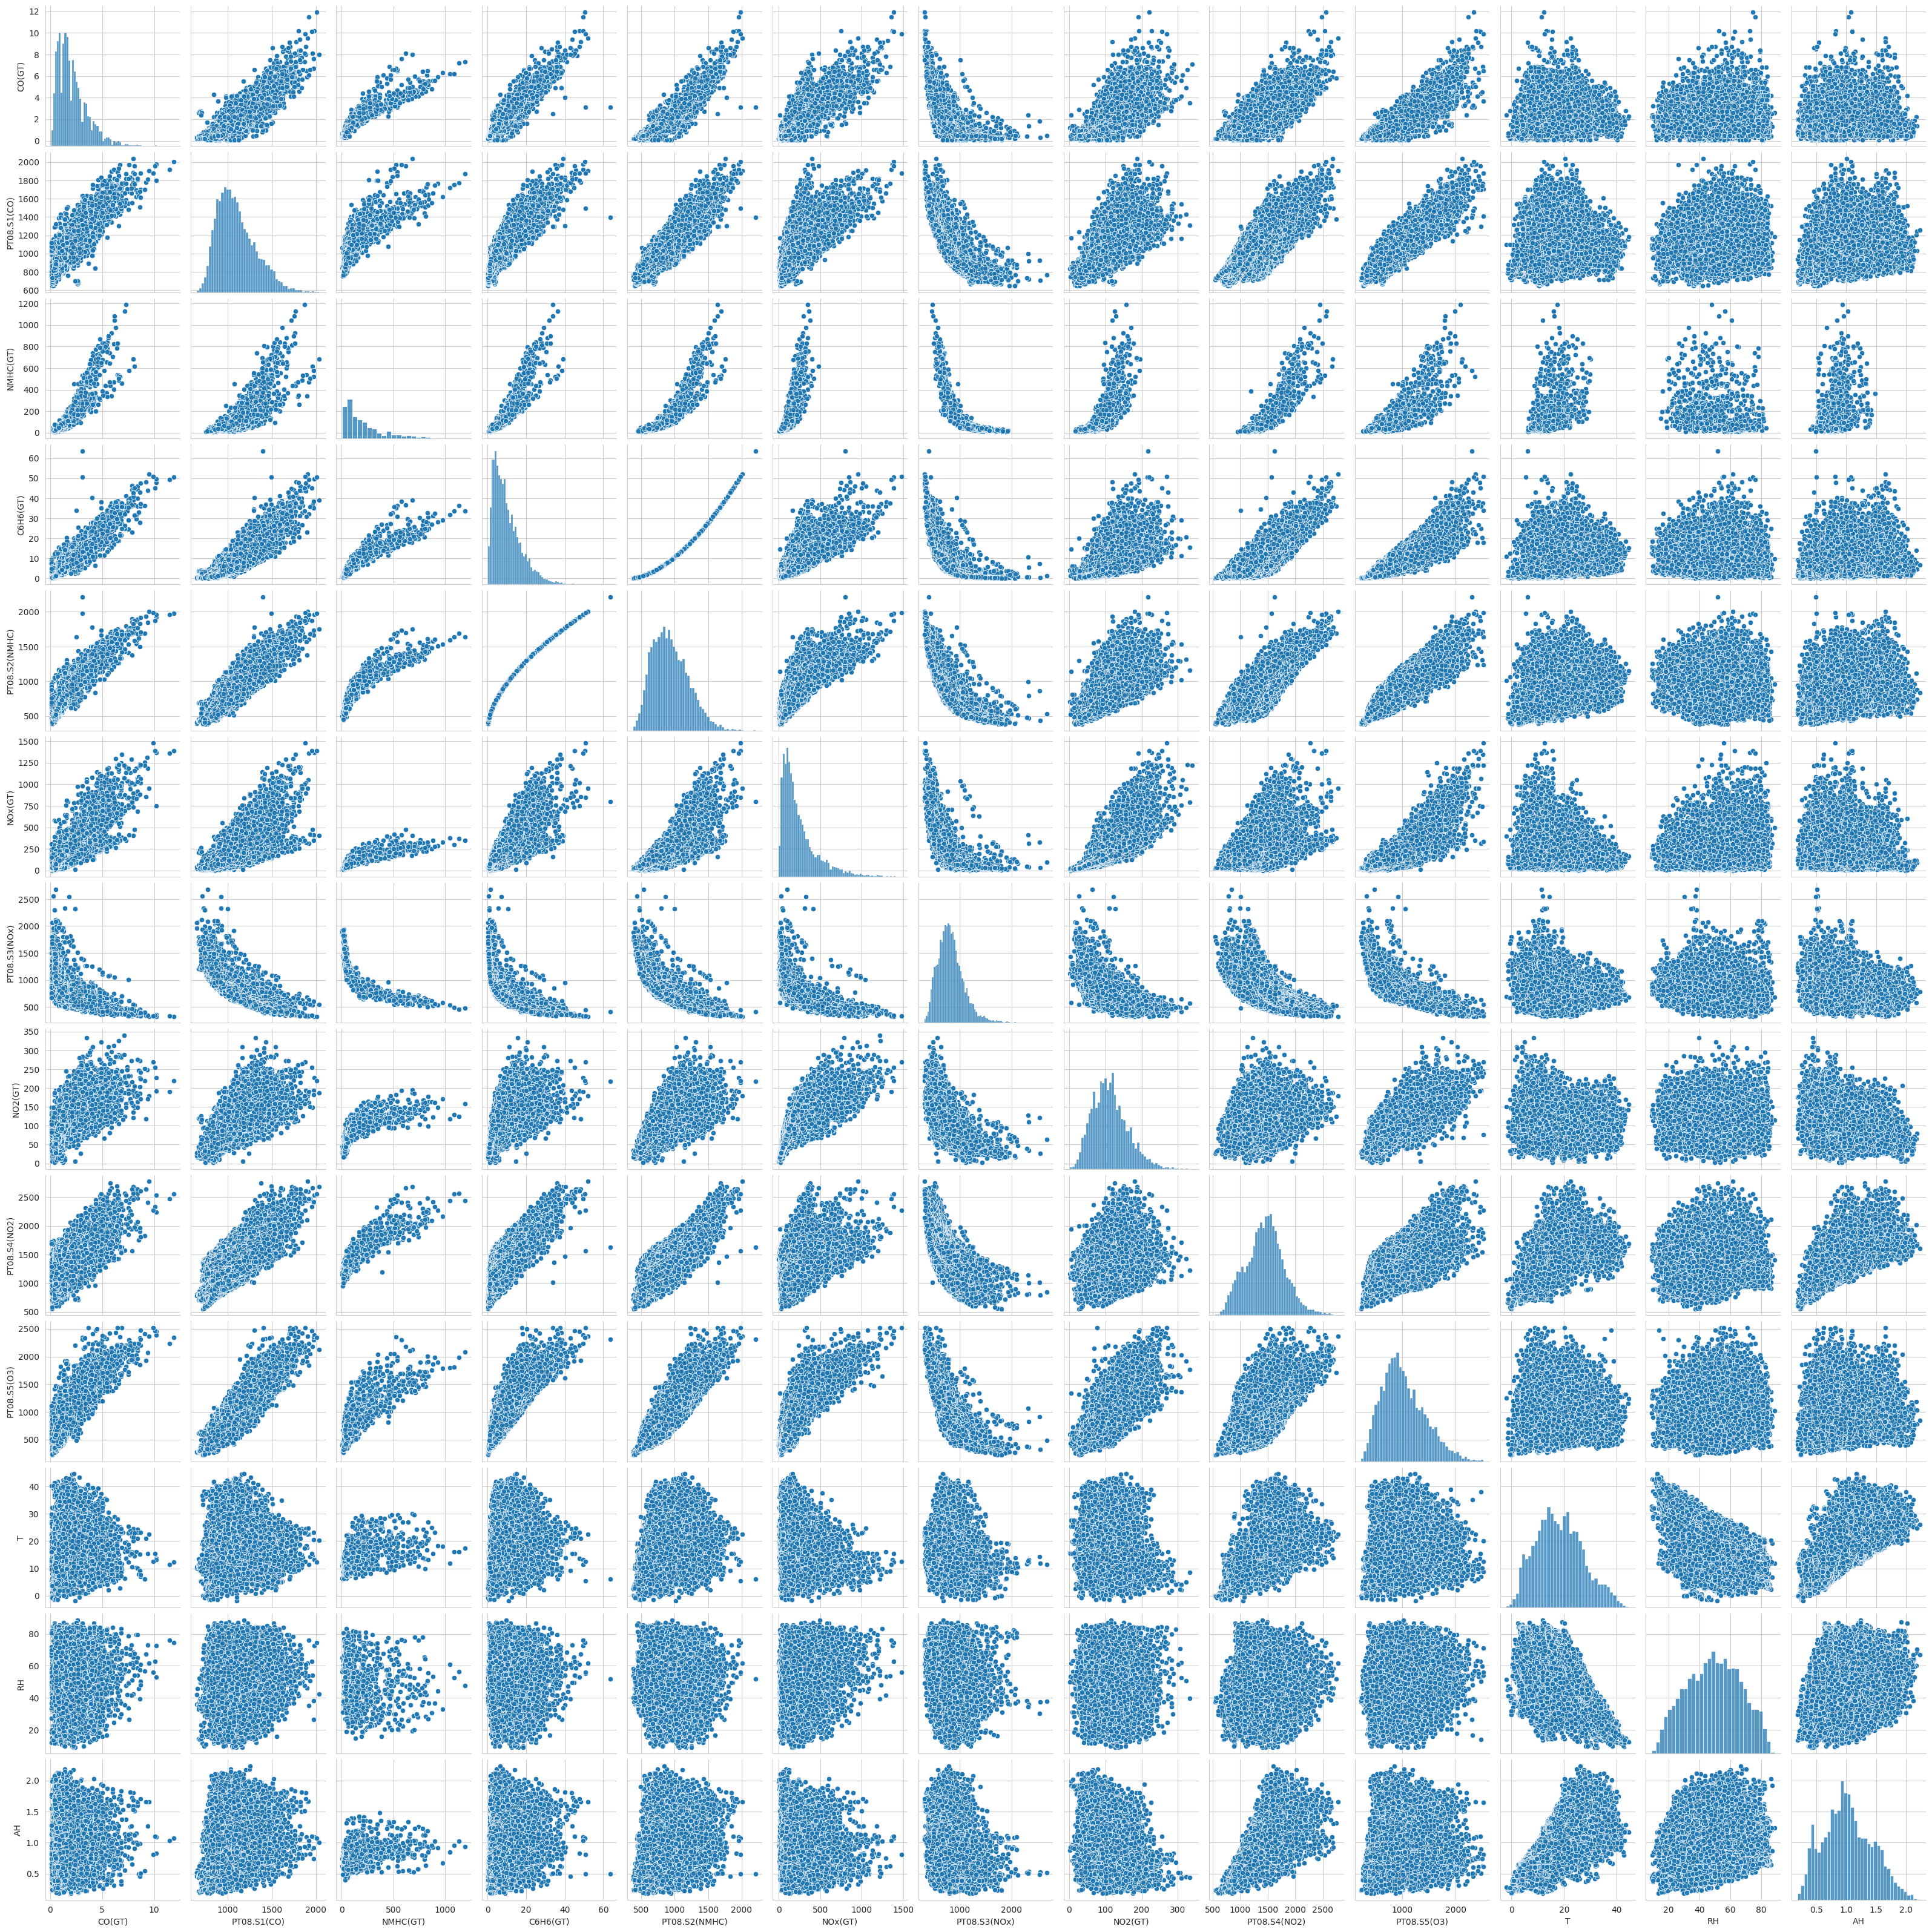

In [5]:
cols = list(df.columns[(df.columns != 'date') & (df.columns != 'time')])
sns.pairplot(df[cols]);

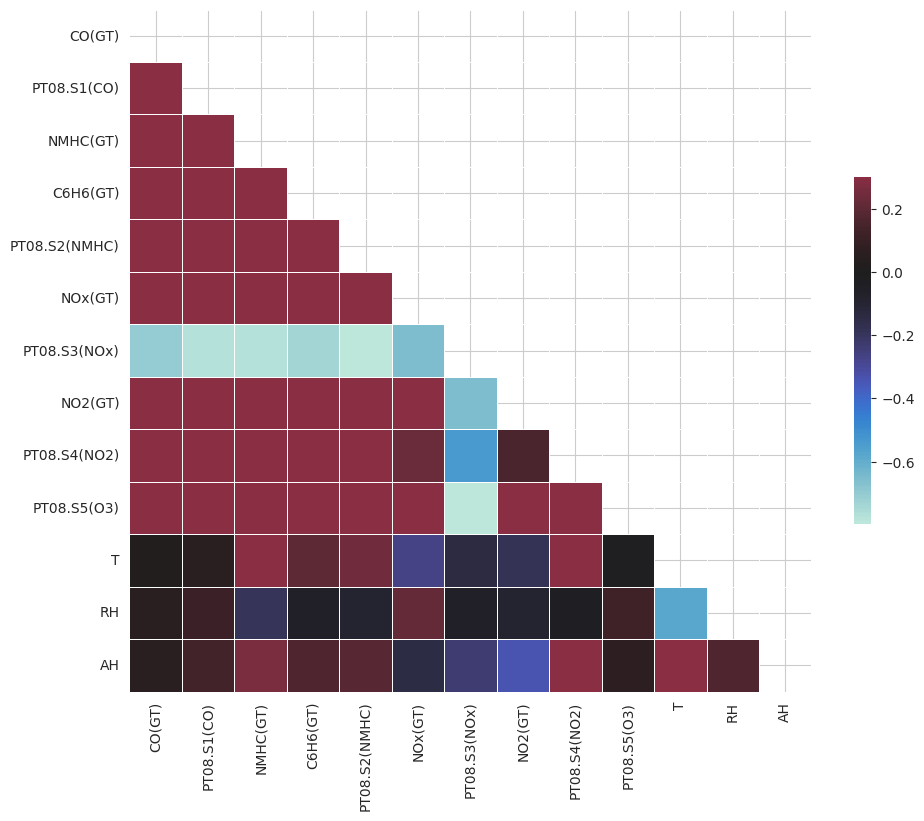

In [6]:
corr = df[cols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
# cmap = sns.color_palette("Blues", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [7]:
df.isnull().sum() * 100 / df.shape[0]

date              0.000000
time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

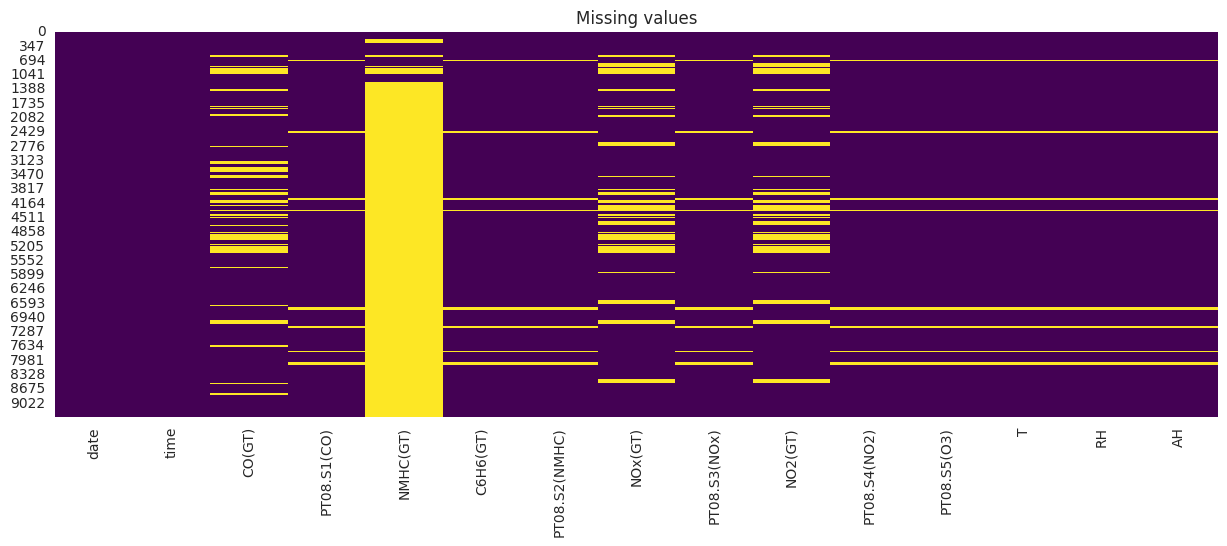

In [8]:
plt.figure(figsize=(15, 5))
plt.title('Missing values')
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()


In [9]:
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.set_index('timestamp')
df = df.drop(columns=['date', 'time'])
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
timestamp                                                                     
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
timestamp                                                           
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   

                     PT08.S5(O3)     T    RH      AH  
timestamp                                             
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578  
2004-03-10 19:00:00        972.0  13.3  47.7  0.7255  
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502  
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867  
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888

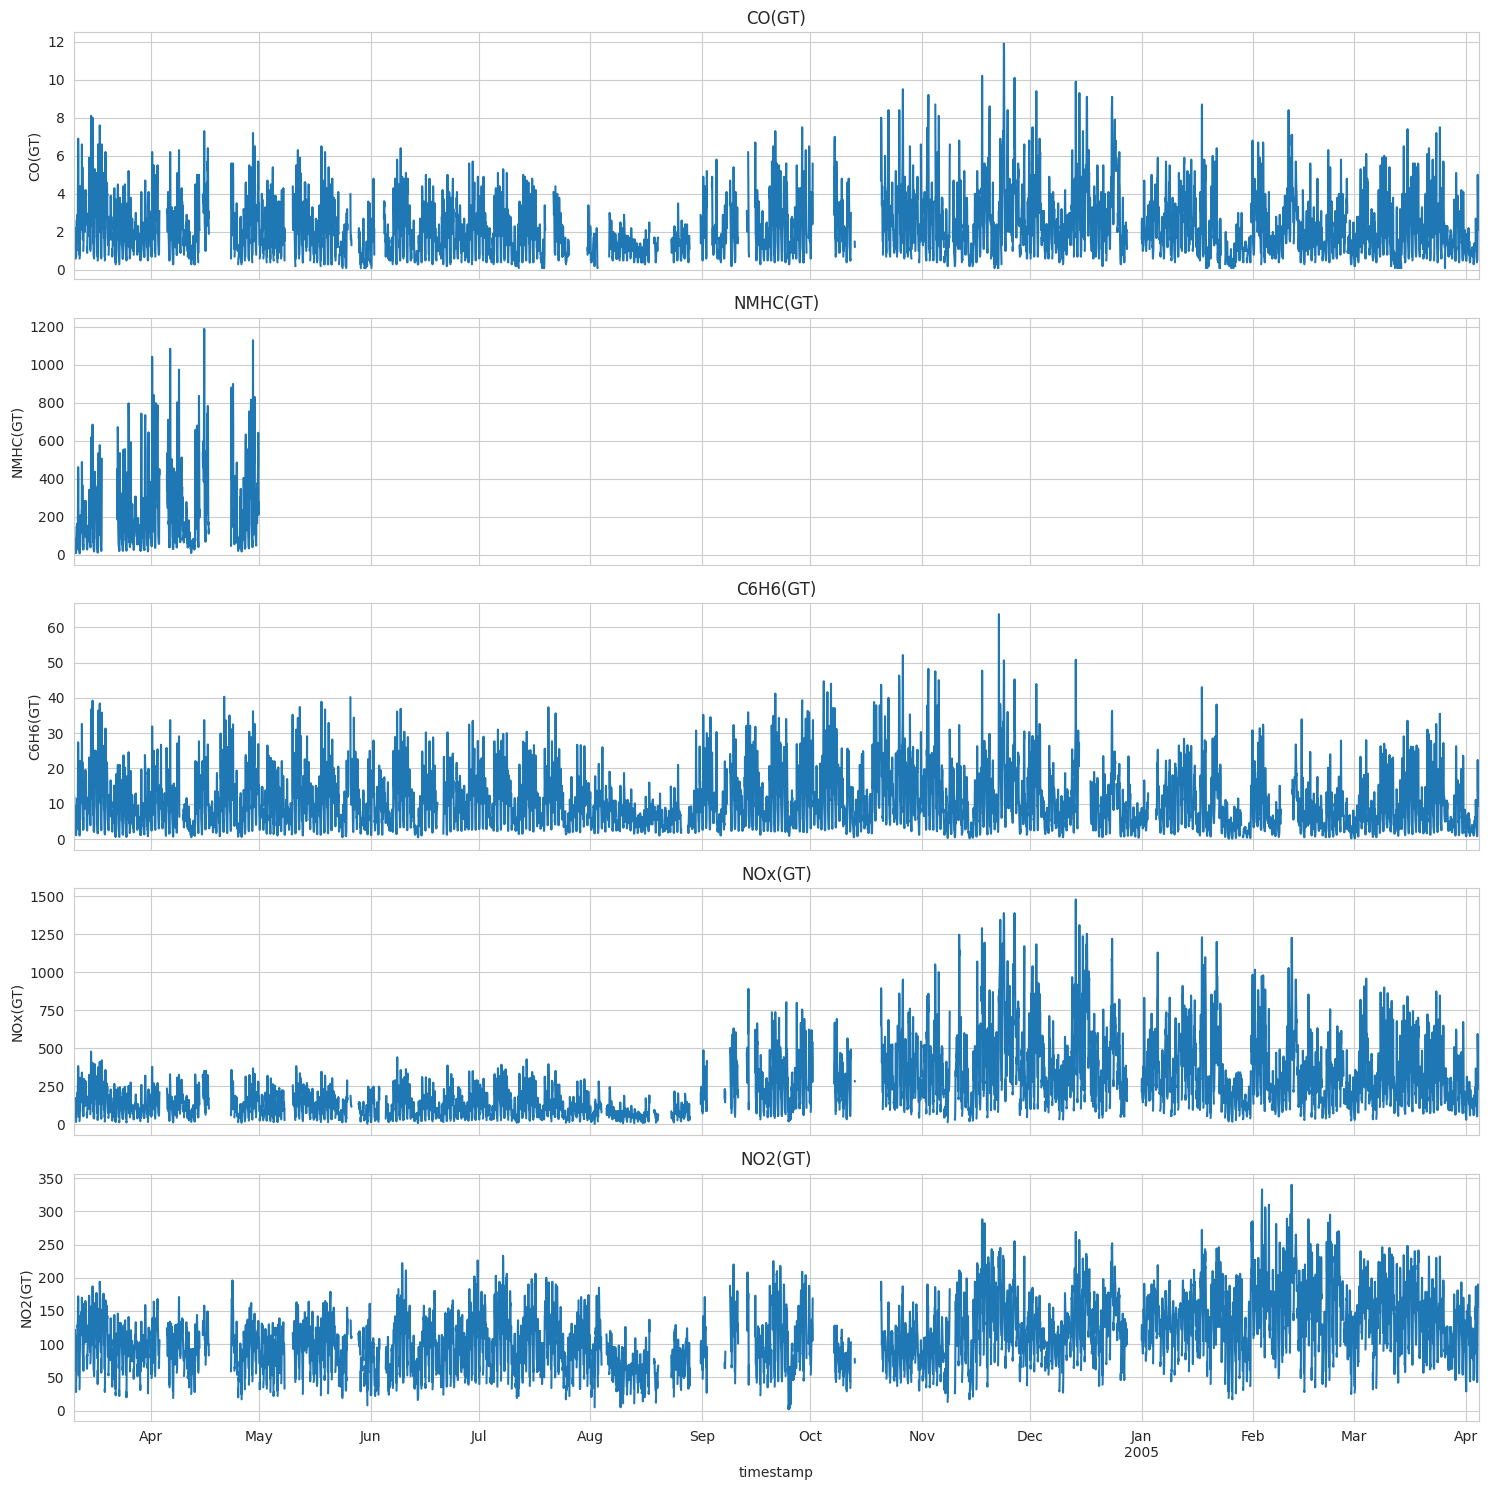

In [10]:
gt_cols = [col for col in df.columns if '(GT)' in col]

fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df[col].plot(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [11]:
del df['NMHC(GT)']
gt_cols.remove('NMHC(GT)')
cols.remove('NMHC(GT)')
df2 = df[cols].copy()
df2[cols] = df2[cols].interpolate()
df2.isnull().sum() * 100 / df2.shape[0]

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

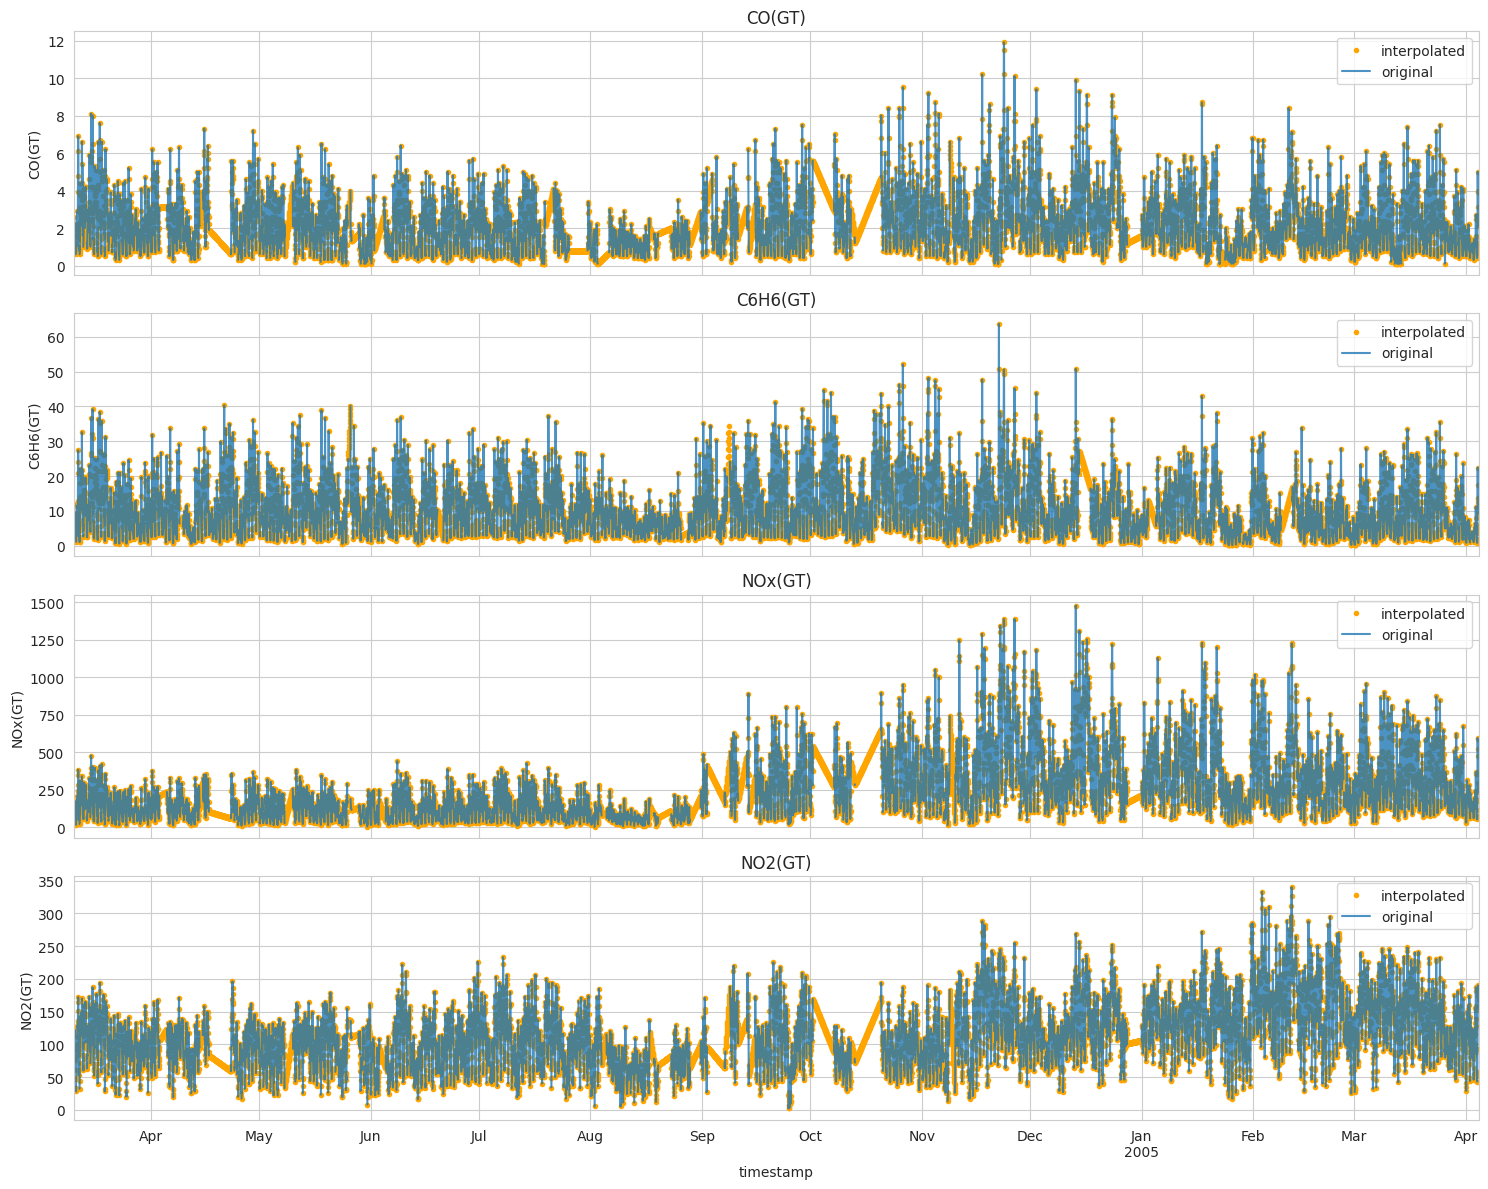

In [12]:
fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df2[col].plot(ax=axes[i], label='interpolated', style='.', color='orange')
    df[col].plot(ax=axes[i], label='original', alpha=0.8, style='-')
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [13]:

# Función para detectar intervalos faltantes (ajustada para timestamps)
def find_missing_intervals(series):
    is_na = series.isna()
    changes = [ j for j in range(1,len(is_na)) if is_na.iloc[j] != is_na.iloc[i-1]]

    # Convertir a lista de tuplas
    missing_intervals = [(df.index[changes[i-1]], df.index[changes[i]]) for i in range(1,len(changes),2)]
    return missing_intervals

def fill_gaps(attribute):

    # Cargar datos y extraer serie (ejemplo con índice datetime)
    serie = df[attribute].copy()

    # 1. Encontrar todos los bloques de NaN
    missing_intervals = find_missing_intervals(serie)

    # 2. Descomposición STL (usando interpolación lineal provisional)
    stl = STL(
        serie.interpolate('linear'),
        period=24,                # Ajustar si hay múltiples estacionalidades
        seasonal=13,              # Ventana más larga para estacionalidad
        robust=True               # Reduce impacto de outliers
    )
    res = stl.fit()


    # Transformación Yeo-Johnson para normalizar residuos
    transformer = PowerTransformer(method='yeo-johnson')
    resid_transformed = transformer.fit_transform(res.resid.dropna().values.reshape(-1, 1)).flatten()

    # Modelar residuos transformados
    model = SARIMAX(
        resid_transformed,
        order=(1, 0, 1),          # Reducir complejidad vs (1,1,1)
        seasonal_order=(0, 1, 1, 24),
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    for start, end in missing_intervals:
        gap_length = len(serie.loc[start:end])

        # 1. Simular residuos transformados
        simulated_transformed = model_fit.simulate(gap_length)

        # 2. Revertir transformación
        simulated_resid = transformer.inverse_transform(
            simulated_transformed.reshape(-1, 1)
        ).flatten()

        # 3. Imputación con límites físicos
        imputed = (
            res.seasonal.loc[start:end] +
            res.trend.loc[start:end] +
            simulated_resid*0.3
        )

        # 4. Forzar rango percentil 1%-99% histórico
        p10, p90 = serie.quantile([0.1, 0.90])
        imputed = np.clip(imputed, p10, p90)

        serie.loc[start:end] = imputed
    return serie

In [14]:
df3 = df.copy()
for i, col in enumerate(gt_cols):
    df3[col] = fill_gaps(col)

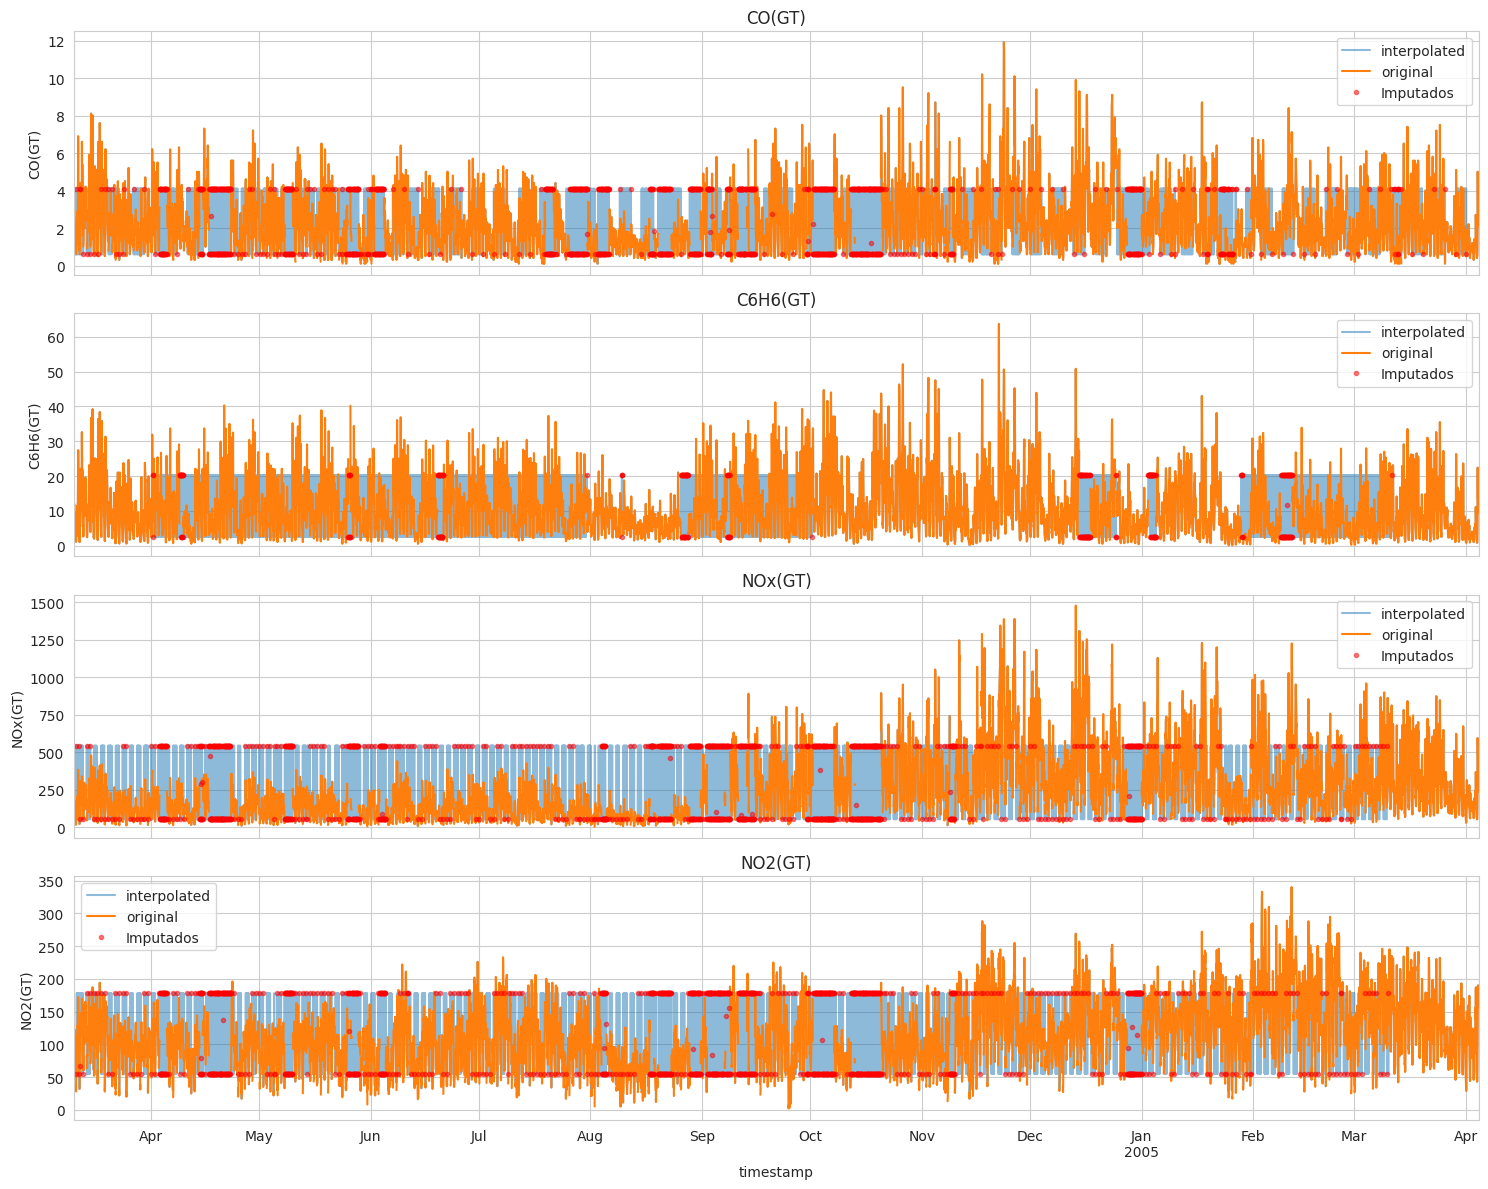

In [15]:

fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    original_nans = df[col].isna()
    df3[col].plot(ax=axes[i], label='interpolated', style='-', alpha=0.5)
    df[col].plot(ax=axes[i], label='original', alpha=1, style='-')
    df3.loc[original_nans,col].plot(ax=axes[i], label='Imputados', style='r.', alpha=0.5,)

    axes[i].set_title(col)
    axes[i].set_ylabel(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [17]:
df2[cols] = df2[cols].interpolate()
df2[cols] = df2[cols].interpolate()

df3.isnull().sum() * 100 / df3.shape[0]

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

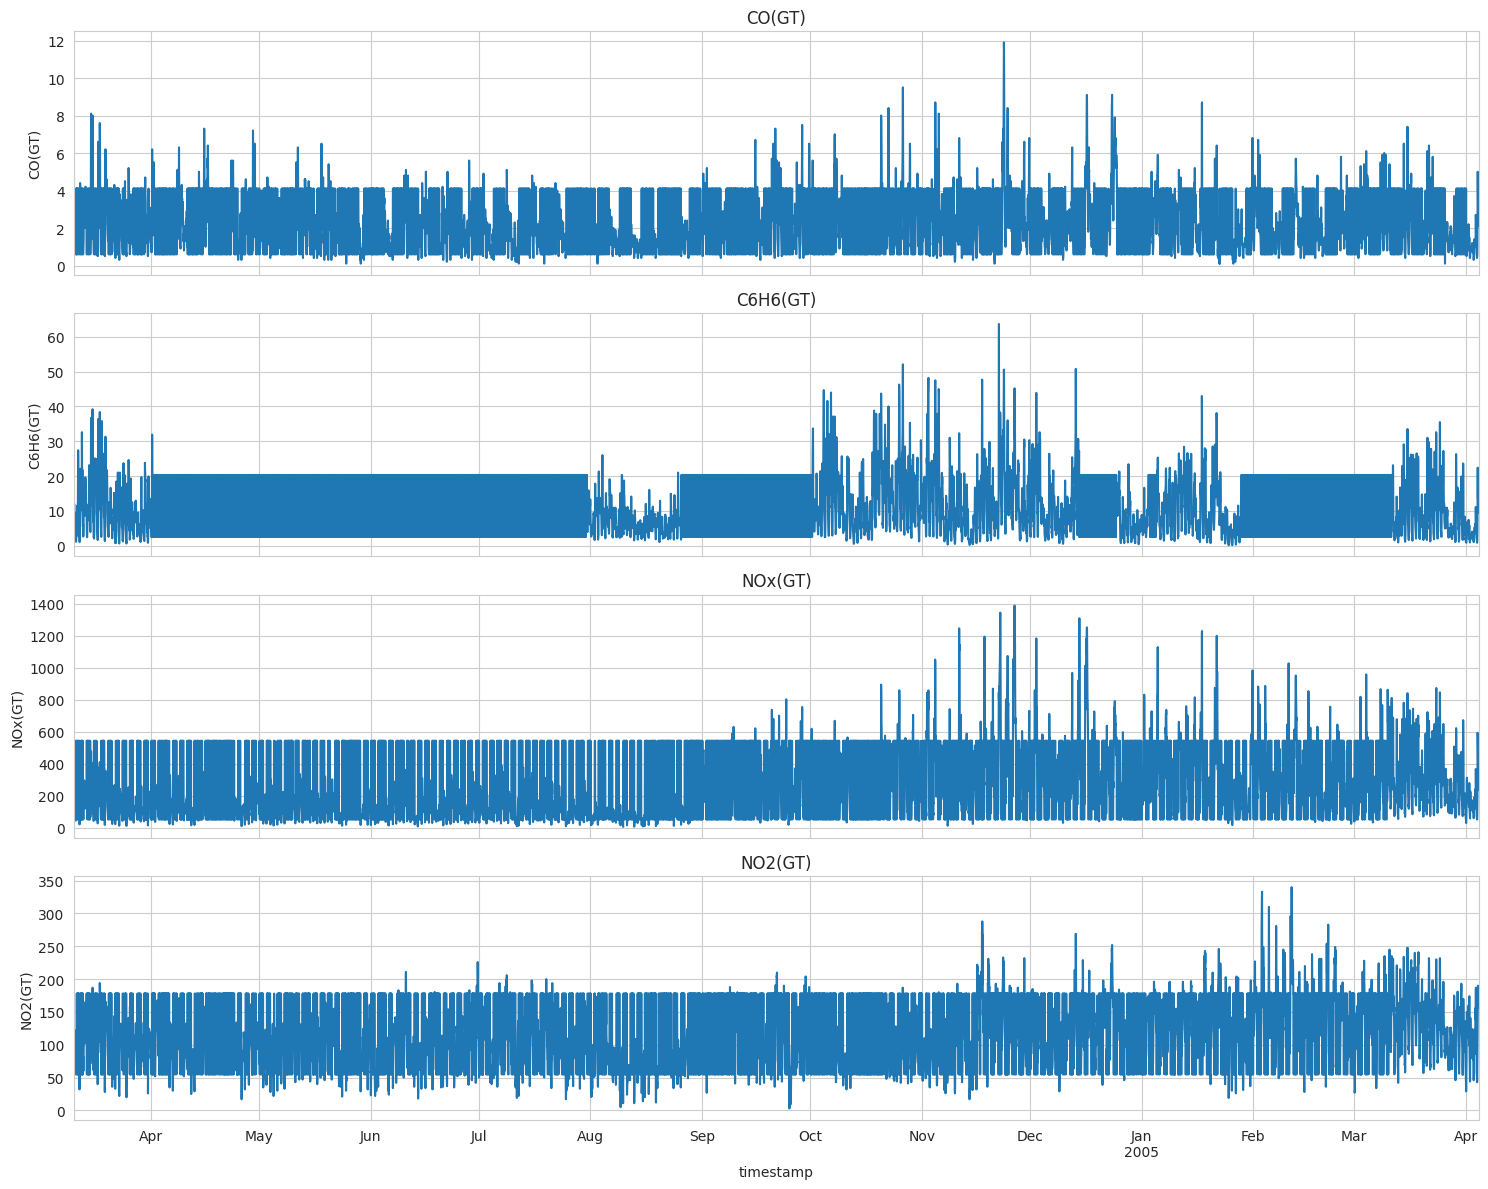

In [19]:
fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df3[col].plot(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

sGap data generation


d

### 🧩 Comparativa de Técnicas de Reducción de Dimensión: `X + Y` vs. Enfoque Híbrido

| Técnica                         | Tipo de reducción     | ¿Supervisada? | ¿Y usada explícitamente? | Dificultad para reconstruir Y | Notas clave |
|----------------------------------|-------------------------|----------------|----------------------------|-------------------------------|-------------|
| **PCA sobre `X + Y`**            | Reducción conjunta      | ❌ No          | ✅ Sí (pero no supervisada) | 🟡 Media                      | Captura varianza conjunta, pero sin optimizar relación con Y. Riesgo de leakage si se usan valores futuros. |
| **PLS sobre `X + Y`**            | Reducción conjunta      | ✅ Sí          | ✅ Sí                      | 🟢 Baja                       | Optimiza componentes para predecir Y. Buena opción si no hay leakage temporal. |
| **Autoencoder sobre `X + Y`**    | Reducción conjunta      | ⚠️ Depende     | ✅ Sí                      | 🟡 Media / 🟢 Baja            | Capta patrones complejos. Riesgo de leakage si no se cuida la estructura temporal. |
| **PCA + fusión con Y**           | Enfoque híbrido         | ⚠️ Parcial     | ✅ Sí (explícito)          | 🟢 Baja                       | PCA sobre X, luego combinas PC1 con Y (por ponderación, concatenación o regresión). |
| **PLS sobre `PC_X + Y`**         | Enfoque híbrido         | ✅ Sí          | ✅ Sí                      | 🟢 Baja                       | Dos etapas: primero reduces X, luego haces reducción supervisada con Y. |
| **Autoencoder sobre `PC_X + Y`** | Enfoque híbrido         | ⚠️ Parcial     | ✅ Sí                      | 🟡 Media / 🟢 Baja            | Similar al anterior, pero usando compresión no lineal tras PCA. Flexible, pero más complejo. |
| **Autoencoder predictivo**       | Enfoque híbrido         | ✅ Sí          | ✅ Sí                      | 🟢 Baja                       | Entrenas un autoencoder o seq2seq para comprimir X y predecir Y explícitamente. Muy efectivo, pero más costoso. |


In [23]:
scaler = StandardScaler(copy=True)
standardized_data = scaler.fit_transform(df2.values)
standardized_data

array([[ 0.32786931,  1.17762737,  0.22934175, ..., -0.52764358,
        -0.01694737, -0.65100169],
       [-0.09122473,  0.8659648 , -0.10384006, ..., -0.561807  ,
        -0.08674084, -0.73131371],
       [ 0.04847328,  1.37012484, -0.15714916, ..., -0.7212363 ,
         0.27967485, -0.66989864],
       ...,
       [ 0.18817129,  0.17847384,  0.29597812, ...,  0.98693476,
        -1.79668073, -0.94241248],
       [-0.02137572, -0.45860112, -0.09051279, ...,  1.14636406,
        -2.07585459, -1.25744445],
       [ 0.04847328, -0.14693855,  0.22934175, ...,  1.16913967,
        -2.09911908, -1.28504394]])

In [25]:

pca = PCA(n_components=10)
pca.fit(standardized_data)

PCA(n_components=10)

In [26]:
pca.explained_variance_

array([6.70801141, 2.46342347, 1.33504724, 0.49382441, 0.39754765,
       0.18025018, 0.13816912, 0.11465996, 0.08236226, 0.04406908])

In [27]:
pca.explained_variance_ratio_

array([0.55894121, 0.20526335, 0.11124205, 0.04114764, 0.03312543,
       0.01501924, 0.01151286, 0.00955398, 0.00686279, 0.00367203])

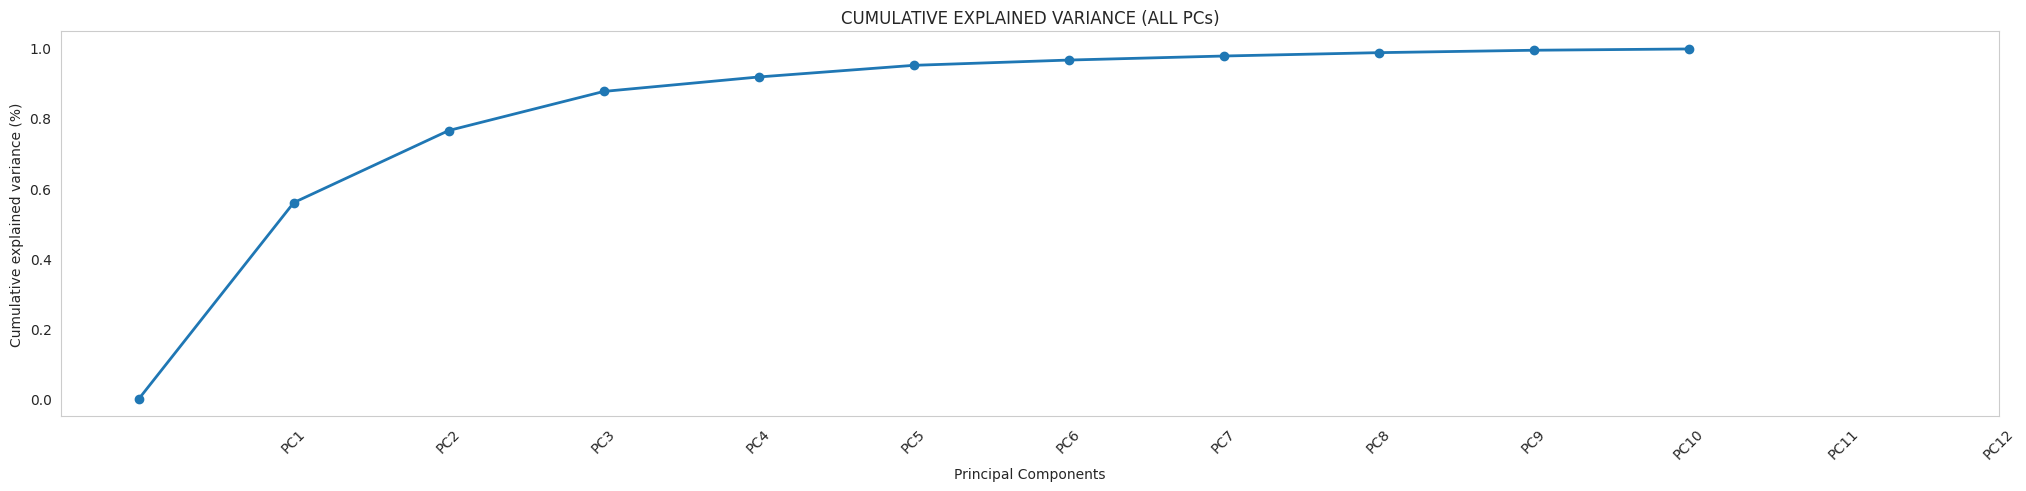

In [28]:
# MAKE THE CUMULATIVE EXPLAINED VARIANCE PLOT
plt.figure(figsize=(25, 5))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0), 'o-', linewidth=2)
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')
plt.xticks(ticks=np.arange(1, pca.n_features_in_ + 1),
           labels=[f'PC{i}' for i in range(1, pca.n_features_in_ + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()


In [31]:
tmp_df = df2.copy()
tmp_df.drop('C6H6(GT)', axis=1, inplace=True)
target = df2['C6H6(GT)']

Explained variance for 1 components (Before): 0.5301752258098048
Explained variance for 2 components (Before): 0.7526321681560563
Explained variance for 3 components (Before): 0.873527745326337
Explained variance for 4 components (Before): 0.9144554070760882
Explained variance for 5 components (Before): 0.9500615973253866
Explained variance for 6 components (Before): 0.9657127507930057
Explained variance for 7 components (Before): 0.9781672858458147
Explained variance for 8 components (Before): 0.9866908262514618
Explained variance for 9 components (Before): 0.9941448237816948


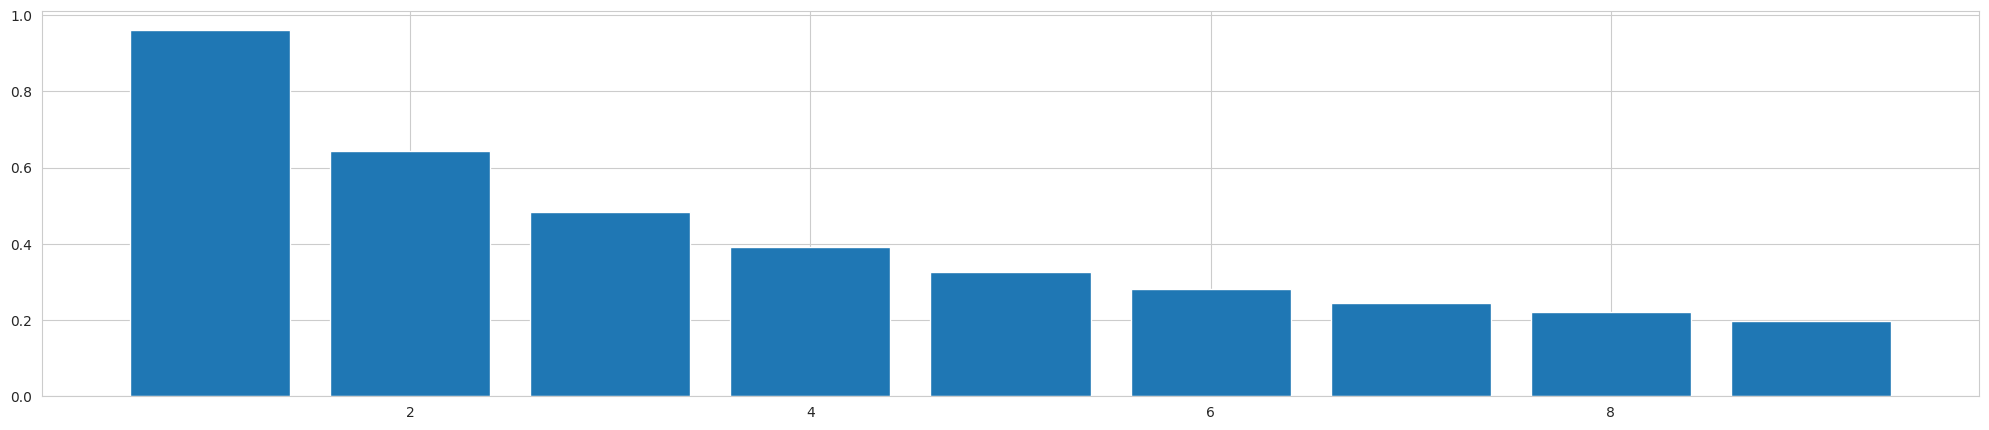

In [32]:
def explained_variance_experiment(X, y, n_components=9):
    variance_explained = []
    scaler = StandardScaler(copy=True)
    X = scaler.fit_transform(X)

    for i in range(1, n_components + 1):
        pca_1 = PCA(n_components=i)
        pca_2 = PCA(n_components=1)
        components = pca_1.fit_transform(X)
        new_X = np.column_stack((components, y))
        new_X = scaler.fit_transform(new_X)
        pca_2.fit_transform(new_X)
        print(f"Explained variance for {i} components (Before): {pca_1.explained_variance_ratio_.sum()}")
        variance_explained.append(pca_2.explained_variance_ratio_.sum())

    plt.figure(figsize=(25, 5))
    plt.bar(range(1, n_components + 1), variance_explained)

    plt.show()


explained_variance_experiment(tmp_df.values, target.values)

In [33]:
pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=1)
components = pca_1.fit_transform(tmp_df.values)
comps_X = np.column_stack((components,target.values))
new_X = pca_2.fit_transform(comps_X)
new_X = scaler.fit_transform(new_X)
new_X

array([[ 0.43920896],
       [-0.12409079],
       [ 0.05108155],
       ...,
       [ 0.16915005],
       [-0.49563239],
       [-0.26208766]])

In [34]:
aux = pd.DataFrame(zip(df2.index, new_X), columns=['date', 'target'])
aux.target = aux.target.astype(float)
aux.date = pd.to_datetime(aux.date)
aux['id_time_series'] = '0'
aux

date    target id_time_series
0    2004-03-10 18:00:00  0.439209              0
1    2004-03-10 19:00:00 -0.124091              0
2    2004-03-10 20:00:00  0.051082              0
3    2004-03-10 21:00:00  0.231207              0
4    2004-03-10 22:00:00 -0.127993              0
...                  ...       ...            ...
9352 2005-04-04 10:00:00  1.098100              0
9353 2005-04-04 11:00:00  0.366785              0
9354 2005-04-04 12:00:00  0.169150              0
9355 2005-04-04 13:00:00 -0.495632              0
9356 2005-04-04 14:00:00 -0.262088              0

[9357 rows x 3 columns]

In [36]:
train_data = TimeSeriesDataFrame.from_data_frame(
    aux,
    id_column="id_time_series",
    timestamp_column="date"
)
train_data = train_data.convert_frequency(freq="d")
train_data

target
item_id timestamp           
0       2004-03-10 -0.011036
        2004-03-11 -0.369288
        2004-03-12  0.127408
        2004-03-13  0.344572
        2004-03-14  0.303144
...                      ...
        2005-03-31 -0.622583
        2005-04-01 -1.215279
        2005-04-02 -1.378333
        2005-04-03 -0.870588
        2005-04-04 -0.208325

[391 rows x 1 columns]

In [37]:
use_cuda = torch.cuda.is_available()
print(
    f"We will use {'chronos_small' if use_cuda else 'bolt_small'} because cuda is {'not ' if not use_cuda else ''}available")

We will use chronos_small because cuda is available


In [52]:


predictor = TimeSeriesPredictor(prediction_length=15).fit(
    train_data, presets="chronos_base" if use_cuda else "bolt_small",
)



Beginning AutoGluon training...
AutoGluon will save models to '/home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting/AutogluonModels/ag-20250625_131612'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202412060638~1748542656~22.04~663e4dc SMP PREEMPT_DYNAMIC Thu M
CPU Count:          16
GPU Count:          1
Memory Avail:       2.84 GB / 15.32 GB (18.5%)
Disk Space Avail:   313.52 GB / 441.91 GB (70.9%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



Model not specified in predict, will default to the model with the best validation score: Chronos[base]


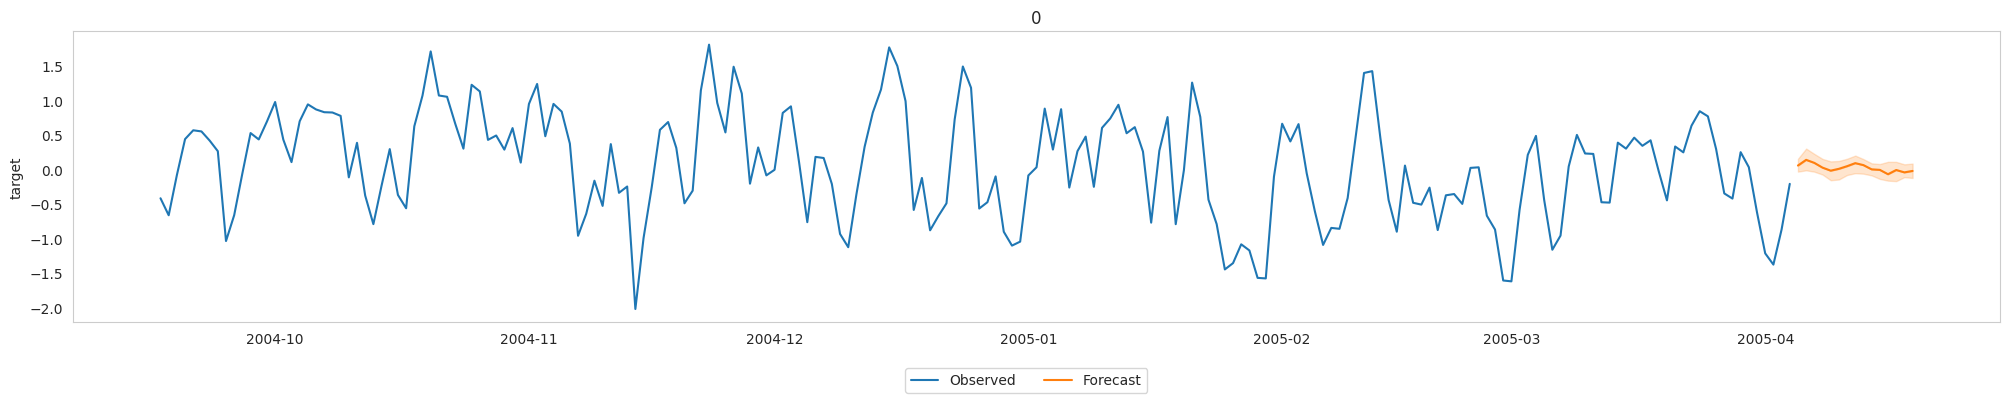

In [53]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=train_data,
    predictions=predictions,
    item_ids=train_data.item_ids[0],
    max_history_length=200,
);

In [54]:
temp_df = pd.DataFrame(new_X, columns=['target'], index=df2.index)
temp_df.index = pd.to_datetime(temp_df.index)

In [55]:
temp_df

target
timestamp                    
2004-03-10 18:00:00  0.439209
2004-03-10 19:00:00 -0.124091
2004-03-10 20:00:00  0.051082
2004-03-10 21:00:00  0.231207
2004-03-10 22:00:00 -0.127993
...                       ...
2005-04-04 10:00:00  1.098100
2005-04-04 11:00:00  0.366785
2005-04-04 12:00:00  0.169150
2005-04-04 13:00:00 -0.495632
2005-04-04 14:00:00 -0.262088

[9357 rows x 1 columns]

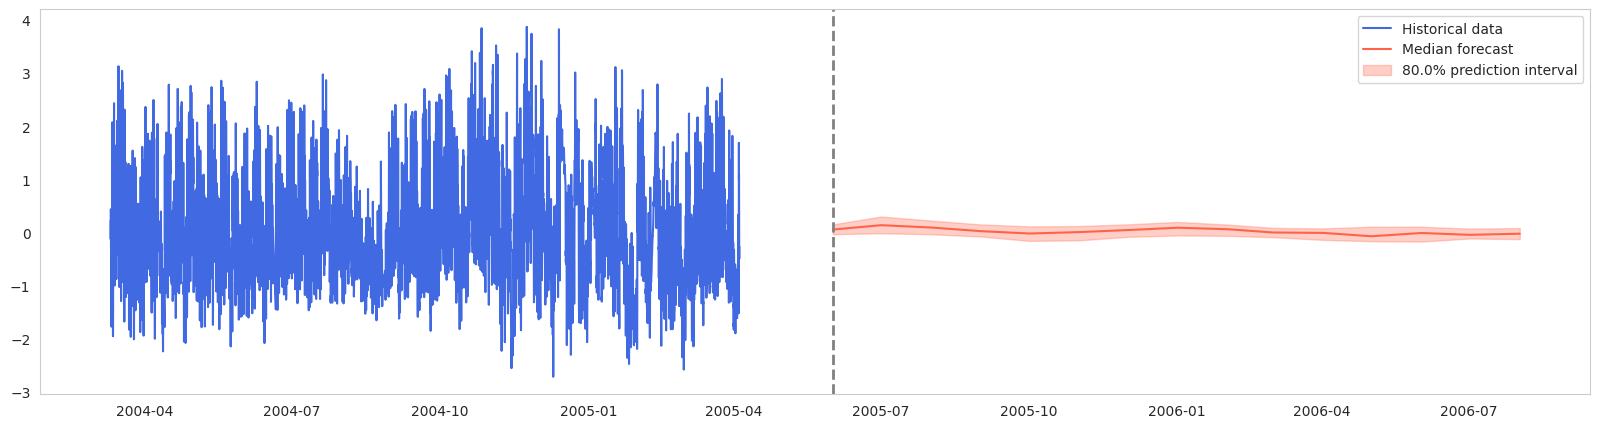

In [56]:
low, median, high = predictions.loc[:, "0.1"], predictions.loc[:, "0.5"], predictions.loc[:, "0.9"]
plot_timeseries_forecasting(temp_df, low, median, high, prediction_length=15)

In [57]:
prediction_length = 15
predictions2 = predictor.predict(train_data.iloc[: -prediction_length])

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


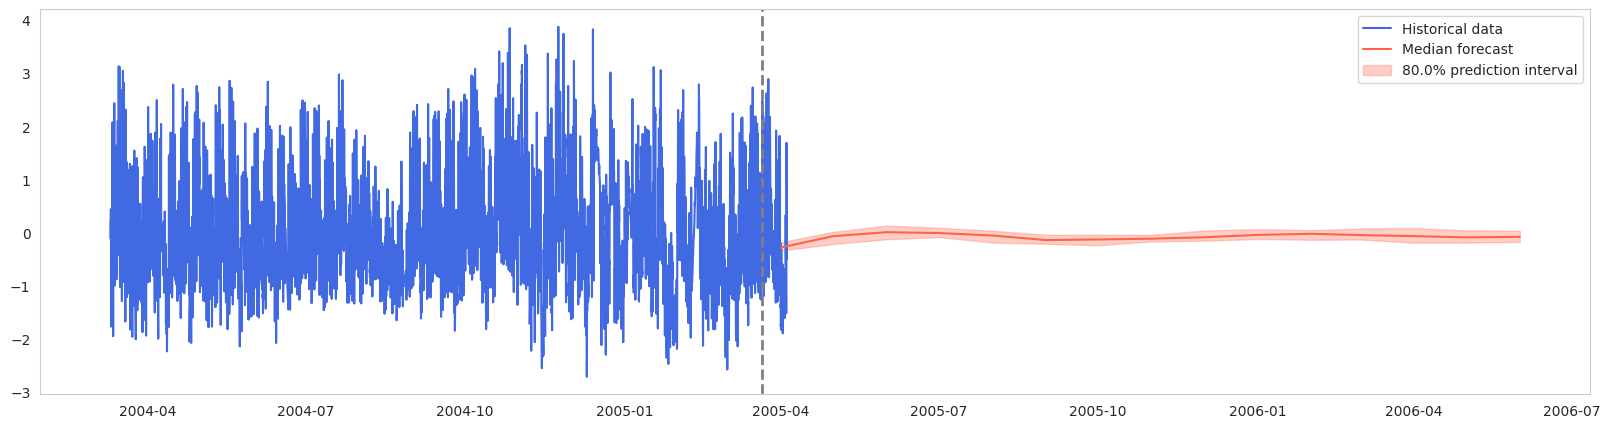

In [58]:
low, median, high = predictions2.loc[:, "0.1"], predictions2.loc[:, "0.5"], predictions2.loc[:, "0.9"]
start_forecasting_date = train_data.index.get_level_values("timestamp")[-prediction_length]
plot_timeseries_forecasting(temp_df, low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length)

In [60]:
df2

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
timestamp                                                                    
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   
...                     ...          ...       ...            ...      ...   
2005-04-04 10:00:00     3.1       1314.0      13.5         1101.0    472.0   
2005-04-04 11:00:00     2.4       1163.0      11.4         1027.0    353.0   
2005-04-04 12:00:00     2.4       1142.0      12.4         1063.0    293.0   
2005-04-04 13:00:00     2.1       1003.0       9.5          961.0    235.0   
2005-04-04 14:00:00     2.2       1071.0      11.9         1047.0    265.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
timestamp                                                                     
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00        1092.0    122.0        1584.0       1203.0  11.0   
2004-03-10 22:00:00        1205.0    116.0        1490.0       1110.0  11.2   
...                           ...      ...           ...          ...   ...   
2005-04-04 10:00:00         539.0    190.0        1374.0       1729.0  21.9   
2005-04-04 11:00:00         604.0    179.0        1264.0       1269.0  24.3   
2005-04-04 12:00:00         603.0    175.0        1241.0       1092.0  26.9   
2005-04-04 13:00:00         702.0    156.0        1041.0        770.0  28.3   
2005-04-04 14:00:00         654.0    168.0        1129.0        816.0  28.5   

                       RH      AH  
timestamp                          
2004-03-10 18:00:00  48.9  0.7578  
2004-03-10 19:00:00  47.7  0.7255  
2004-03-10 20:00:00  54.0  0.7502  
2004-03-10 21:00:00  60.0  0.7867  
2004-03-10 22:00:00  59.6  0.7888  
...                   ...     ...  
2005-04-04 10:00:00  29.3  0.7568  
2005-04-04 11:00:00  23.7  0.7119  
2005-04-04 12:00:00  18.3  0.6406  
2005-04-04 13:00:00  13.5  0.5139  
2005-04-04 14:00:00  13.1  0.5028  

[9357 rows x 12 columns]

In [65]:
df_forecast = df2.copy()
df_forecast['timestamp'] = df_forecast.index
df_forecast['id'] = '0'

In [66]:
timeseries = TimeSeriesDataFrame.from_data_frame(df_forecast, id_column="id", timestamp_column="timestamp")
timeseries = timeseries.convert_frequency(freq="d")
timeseries

CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                     
0       2004-03-10  1.966667  1316.500000   8.450000     912.333333   
        2004-03-11  2.172917  1244.166667   7.979167     851.958333   
        2004-03-12  2.756250  1281.666667  12.129167    1008.291667   
        2004-03-13  2.639583  1330.666667  10.916667     992.833333   
        2004-03-14  2.441667  1361.125000   9.637500     943.916667   
...                      ...          ...        ...            ...   
        2005-03-31  1.387500  1008.125000   5.220833     749.416667   
        2005-04-01  1.083333   903.291667   3.412500     663.000000   
        2005-04-02  0.854167   890.958333   2.529167     616.291667   
        2005-04-03  1.141667   981.375000   4.316667     714.708333   
        2005-04-04  1.970000  1090.533333   8.440000     862.266667   

                       NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                        
0       2004-03-10  132.000000   1167.333333  108.833333   1545.500000   
        2004-03-11  139.750000   1277.250000   97.666667   1522.833333   
        2004-03-12  171.687500   1101.875000  114.625000   1627.291667   
        2004-03-13  180.750000    993.208333  117.354167   1595.791667   
        2004-03-14  144.625000   1001.291667  109.666667   1602.375000   
...                        ...           ...         ...           ...   
        2005-03-31  185.083333    795.666667  100.708333   1176.541667   
        2005-04-01  161.833333    946.875000  107.333333    943.250000   
        2005-04-02  142.375000    991.750000  100.166667    864.333333   
        2005-04-03  167.666667    856.166667  111.125000    985.166667   
        2005-04-04  263.333333    745.266667  122.000000   1195.066667   

                    PT08.S5(O3)          T         RH        AH  
item_id timestamp                                                
0       2004-03-10  1096.000000  12.033333  54.900000  0.765633  
        2004-03-11   885.250000   9.837500  64.075000  0.775767  
        2004-03-12  1084.375000  11.287500  51.095833  0.663104  
        2004-03-13  1245.916667  12.866667  51.533333  0.732296  
        2004-03-14  1234.208333  16.012500  48.850000  0.849671  
...                         ...        ...        ...       ...  
        2005-03-31   763.833333  17.550000  50.083333  0.951917  
        2005-04-01   523.958333  15.929167  35.962500  0.636529  
        2005-04-02   481.750000  15.483333  32.225000  0.546167  
        2005-04-03   717.083333  18.383333  33.695833  0.617583  
        2005-04-04   995.266667  16.960000  42.786667  0.724787  

[391 rows x 12 columns]

In [67]:
prediction_length = 10
train_data, test_data = timeseries.train_test_split(prediction_length=prediction_length)

In [68]:
train_data

CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                     
0       2004-03-10  1.966667  1316.500000   8.450000     912.333333   
        2004-03-11  2.172917  1244.166667   7.979167     851.958333   
        2004-03-12  2.756250  1281.666667  12.129167    1008.291667   
        2004-03-13  2.639583  1330.666667  10.916667     992.833333   
        2004-03-14  2.441667  1361.125000   9.637500     943.916667   
...                      ...          ...        ...            ...   
        2005-03-21  2.545833  1226.750000  11.029167     967.958333   
        2005-03-22  2.433333  1197.916667  10.620833     958.166667   
        2005-03-23  2.877083  1273.000000  13.116667    1039.916667   
        2005-03-24  2.675000  1343.416667  13.337500    1052.250000   
        2005-03-25  2.504167  1341.791667  12.995833    1051.291667   

                       NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                        
0       2004-03-10  132.000000   1167.333333  108.833333   1545.500000   
        2004-03-11  139.750000   1277.250000   97.666667   1522.833333   
        2004-03-12  171.687500   1101.875000  114.625000   1627.291667   
        2004-03-13  180.750000    993.208333  117.354167   1595.791667   
        2004-03-14  144.625000   1001.291667  109.666667   1602.375000   
...                        ...           ...         ...           ...   
        2005-03-21  318.541667    617.625000  136.500000   1425.875000   
        2005-03-22  290.916667    638.416667  123.708333   1365.125000   
        2005-03-23  379.708333    581.625000  140.791667   1425.000000   
        2005-03-24  417.833333    555.791667  135.875000   1452.041667   
        2005-03-25  369.791667    549.083333  137.291667   1560.458333   

                    PT08.S5(O3)          T         RH        AH  
item_id timestamp                                                
0       2004-03-10  1096.000000  12.033333  54.900000  0.765633  
        2004-03-11   885.250000   9.837500  64.075000  0.775767  
        2004-03-12  1084.375000  11.287500  51.095833  0.663104  
        2004-03-13  1245.916667  12.866667  51.533333  0.732296  
        2004-03-14  1234.208333  16.012500  48.850000  0.849671  
...                         ...        ...        ...       ...  
        2005-03-21  1154.500000  16.616667  55.529167  1.005646  
        2005-03-22  1153.958333  17.108333  51.504167  0.946092  
        2005-03-23  1346.791667  18.812500  44.983333  0.910521  
        2005-03-24  1467.750000  17.166667  49.566667  0.951550  
        2005-03-25  1334.708333  17.687500  62.758333  1.232358  

[381 rows x 12 columns]

In [71]:
covar_labels = list(timeseries.columns)
covar_labels.remove('C6H6(GT)')
covar_labels

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [72]:
covariates  = test_data.drop('C6H6(GT)', axis=1, inplace=False)
covariates[covar_labels].iloc[-prediction_length:]

CO(GT)  PT08.S1(CO)  PT08.S2(NMHC)     NOx(GT)  \
item_id timestamp                                                      
0       2005-03-26  1.716667  1216.541667     910.541667  252.041667   
        2005-03-27  1.337500  1106.333333     723.166667  184.916667   
        2005-03-28  1.500000  1079.666667     745.166667  202.708333   
        2005-03-29  2.262500  1163.333333     943.416667  302.666667   
        2005-03-30  1.916667  1106.000000     908.791667  261.208333   
        2005-03-31  1.387500  1008.125000     749.416667  185.083333   
        2005-04-01  1.083333   903.291667     663.000000  161.833333   
        2005-04-02  0.854167   890.958333     616.291667  142.375000   
        2005-04-03  1.141667   981.375000     714.708333  167.666667   
        2005-04-04  1.970000  1090.533333     862.266667  263.333333   

                    PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
item_id timestamp                                                         
0       2005-03-26    590.041667  106.541667   1407.250000  1185.875000   
        2005-03-27    726.041667   92.583333   1305.041667   884.750000   
        2005-03-28    748.125000  103.041667   1280.750000   829.583333   
        2005-03-29    632.083333  123.000000   1429.958333  1133.333333   
        2005-03-30    665.833333  122.125000   1328.666667  1067.416667   
        2005-03-31    795.666667  100.708333   1176.541667   763.833333   
        2005-04-01    946.875000  107.333333    943.250000   523.958333   
        2005-04-02    991.750000  100.166667    864.333333   481.750000   
        2005-04-03    856.166667  111.125000    985.166667   717.083333   
        2005-04-04    745.266667  122.000000   1195.066667   995.266667   

                            T         RH        AH  
item_id timestamp                                   
0       2005-03-26  18.954167  57.900000  1.226221  
        2005-03-27  15.612500  72.450000  1.270142  
        2005-03-28  17.933333  60.766667  1.186071  
        2005-03-29  15.916667  62.537500  1.116463  
        2005-03-30  17.433333  54.037500  0.996762  
        2005-03-31  17.550000  50.083333  0.951917  
        2005-04-01  15.929167  35.962500  0.636529  
        2005-04-02  15.483333  32.225000  0.546167  
        2005-04-03  18.383333  33.695833  0.617583  
        2005-04-04  16.960000  42.786667  0.724787

In [73]:
test_data

CO(GT)  PT08.S1(CO)   C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                     
0       2004-03-10  1.966667  1316.500000   8.450000     912.333333   
        2004-03-11  2.172917  1244.166667   7.979167     851.958333   
        2004-03-12  2.756250  1281.666667  12.129167    1008.291667   
        2004-03-13  2.639583  1330.666667  10.916667     992.833333   
        2004-03-14  2.441667  1361.125000   9.637500     943.916667   
...                      ...          ...        ...            ...   
        2005-03-31  1.387500  1008.125000   5.220833     749.416667   
        2005-04-01  1.083333   903.291667   3.412500     663.000000   
        2005-04-02  0.854167   890.958333   2.529167     616.291667   
        2005-04-03  1.141667   981.375000   4.316667     714.708333   
        2005-04-04  1.970000  1090.533333   8.440000     862.266667   

                       NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                        
0       2004-03-10  132.000000   1167.333333  108.833333   1545.500000   
        2004-03-11  139.750000   1277.250000   97.666667   1522.833333   
        2004-03-12  171.687500   1101.875000  114.625000   1627.291667   
        2004-03-13  180.750000    993.208333  117.354167   1595.791667   
        2004-03-14  144.625000   1001.291667  109.666667   1602.375000   
...                        ...           ...         ...           ...   
        2005-03-31  185.083333    795.666667  100.708333   1176.541667   
        2005-04-01  161.833333    946.875000  107.333333    943.250000   
        2005-04-02  142.375000    991.750000  100.166667    864.333333   
        2005-04-03  167.666667    856.166667  111.125000    985.166667   
        2005-04-04  263.333333    745.266667  122.000000   1195.066667   

                    PT08.S5(O3)          T         RH        AH  
item_id timestamp                                                
0       2004-03-10  1096.000000  12.033333  54.900000  0.765633  
        2004-03-11   885.250000   9.837500  64.075000  0.775767  
        2004-03-12  1084.375000  11.287500  51.095833  0.663104  
        2004-03-13  1245.916667  12.866667  51.533333  0.732296  
        2004-03-14  1234.208333  16.012500  48.850000  0.849671  
...                         ...        ...        ...       ...  
        2005-03-31   763.833333  17.550000  50.083333  0.951917  
        2005-04-01   523.958333  15.929167  35.962500  0.636529  
        2005-04-02   481.750000  15.483333  32.225000  0.546167  
        2005-04-03   717.083333  18.383333  33.695833  0.617583  
        2005-04-04   995.266667  16.960000  42.786667  0.724787  

[391 rows x 12 columns]

In [75]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target= 'C6H6(GT)',
    known_covariates_names= covar_labels,
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting/AutogluonModels/ag-20250625_133234'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202412060638~1748542656~22.04~663e4dc SMP PREEMPT_DYNAMIC Thu M
CPU Count:          16
GPU Count:          1
Memory Avail:       2.53 GB / 15.32 GB (16.5%)
Disk Space Avail:   313.51 GB / 441.91 GB (70.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                   

In [76]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


model  score_test  score_val  pred_time_test  \
0  ChronosZeroShot[bolt_small]   -0.393267  -0.092432        1.096396   

   pred_time_val  fit_time_marginal  fit_order  
0       1.569105           0.007519          1

In [77]:
predictions3 = predictor.predict(
    test_data.iloc[: -prediction_length], known_covariates=covariates[covar_labels].iloc[-prediction_length:])

Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


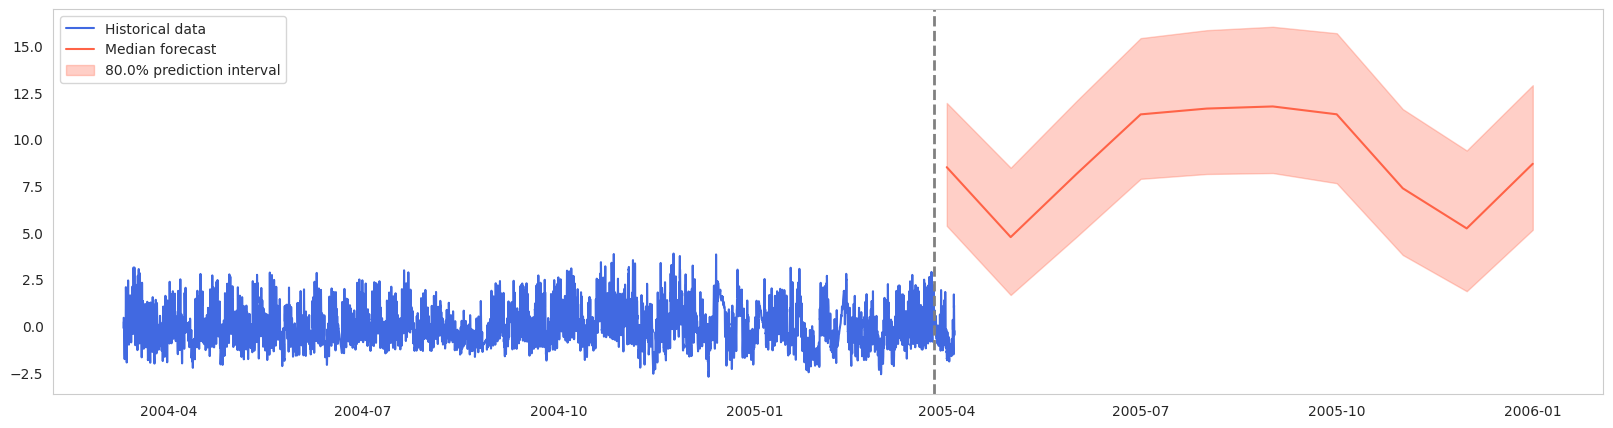

In [78]:
low, median, high = predictions3.loc[:, "0.1"], predictions3.loc[:, "0.5"], predictions3.loc[:, "0.9"]
start_forecasting_date = test_data.index.get_level_values("timestamp")[-prediction_length]
plot_timeseries_forecasting(temp_df, low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length)